<a href="https://colab.research.google.com/github/ptx-pluto/colab-notebooks/blob/master/drake_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake.
if 'google.colab' in sys.modules and importlib.util.find_spec('manipulation') is None:
    urlretrieve(f"http://manipulation.csail.mit.edu/scripts/setup/setup_manipulation_colab.py",
                "setup_manipulation_colab.py")
    from setup_manipulation_colab import setup_manipulation
    setup_manipulation(manipulation_sha='c1bdae733682f8a390f848bc6cb0dbbf9ea98602', drake_version='0.25.0', drake_build='releases')

from manipulation import running_as_notebook

In [6]:
import matplotlib.pyplot as plt
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogOutput
from pydrake.symbolic import Variable
from pydrake.systems.primitives import SymbolicVectorSystem
from pydrake.systems.framework import BasicVector, LeafSystem

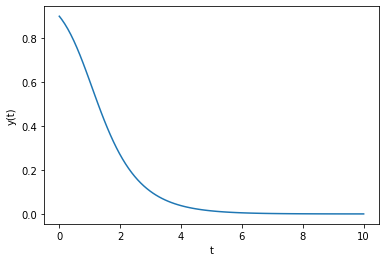

In [7]:
# Create a simple block diagram containing our system.
builder = DiagramBuilder()
x = Variable("x")
system = builder.AddSystem(SymbolicVectorSystem(state=[x], dynamics=[-x + x**3], output=[x]))
logger = LogOutput(system.get_output_port(0), builder)
diagram = builder.Build()

# Set the initial conditions, x(0).
context = diagram.CreateDefaultContext()
context.SetContinuousState([0.9])

# Create the simulator, and simulate for 10 seconds.
simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)

# Plot the results.
plt.figure()
plt.plot(logger.sample_times(), logger.data().transpose())
plt.xlabel('t')
plt.ylabel('y(t)');

In [16]:
class MyPendulum:

  g = 9.8

  def __init__(self,m,l):
    self.m = m
    self.l = l
    self.ddq = self.derive_ddq()
    pass

  def derive_ddq(self):
    from sympy import Function, symbols, sin, cos, solve, Eq
    from sympy.utilities import lambdify
    t = symbols('t')
    q = Function('q')(t)
    dq = Function('dq')(t)
    ddq, l, m, g = symbols('ddq l m g')

    x = l * cos(q)
    y = l * -sin(q)

    sub_rule = [(q.diff(t),dq),(dq.diff(t),ddq)]

    dx = x.diff(t).subs(sub_rule)
    dy = y.diff(t).subs(sub_rule)

    T = 0.5 * m * (dx**2 +dy**2)
    V = m * g * y

    L = T-V

    eom = L.diff(dq).diff(t) - L.diff(q)
    eom = eom.subs(sub_rule)
    sol = solve(Eq(eom,0),ddq)[0]

    sol = sol.subs([(g,self.g),(l,self.l),(m,self.m)])

    return lambdify([q,dq],sol)

  def eom(self,x):
    q = x[0]
    dq = x[1]
    return [dq,self.ddq(q,dq)];

pen = MyPendulum(1,1)

In [38]:
class MyPendulumSystem(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)
        
        self.pen = MyPendulum(1,1)
        self.DeclareContinuousState(2) # One state variable.
        self.DeclareVectorOutputPort("xdot", BasicVector(2), self.CopyStateOut) # One output.

    def DoCalcTimeDerivatives(self, context, derivatives):
        x = context.get_continuous_state_vector().CopyToVector()
        xdot = pen.eom(x)
        derivatives.get_mutable_vector().SetFromVector(xdot)

    # y = x
    def CopyStateOut(self, context, output):
        x = context.get_continuous_state_vector().CopyToVector()
        output.SetFromVector(x)

In [39]:
# Create a simple block diagram containing our system.
builder = DiagramBuilder()
system = builder.AddSystem(MyPendulumSystem())
logger = LogOutput(system.get_output_port(0), builder)
diagram = builder.Build()

# Set the initial conditions, x(0).
context = diagram.CreateDefaultContext()
context.SetContinuousState([0.9,0])

# Create the simulator, and simulate for 10 seconds.
simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)

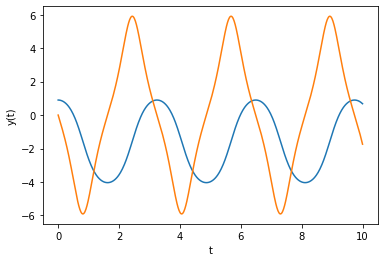

In [40]:
dat = logger.data()
vt = logger.sample_times()
vq = dat[0,:]
vdq = dat[1,:]

plt.figure()
plt.plot(vt,vq)
plt.plot(vt,vdq)

plt.xlabel('t')
plt.ylabel('y(t)');

In [95]:
def derive_double_pendulum_ddq():
  from sympy import Function, symbols, sin, cos, solve, Eq, simplify
  from sympy.utilities import lambdify
  t = symbols('t')
  g = symbols('g')
  q1 = Function('q1')(t)
  q2 = Function('q2')(t)
  dq1 = Function('dq1')(t)
  dq2 = Function('dq2')(t)
  ddq1, ddq2 = symbols('ddq1 ddq2')
  l1, l2 = symbols('l1 l2')
  m1, m2 = symbols('m1 m2')

  x1 = l1 * cos(q1)
  y1 = -l1 * sin(q1)
  x2 = x1 + l2 * cos(q1+q2)
  y2 = y1 - l2 * sin(q1+q2)

  rule = [(q1.diff(t),dq1),(q2.diff(t),dq2), (dq1.diff(t),ddq1), (dq2.diff(t),ddq2)]

  dx1 = x1.diff(t).subs(rule)
  dy1 = y1.diff(t).subs(rule)
  dx2 = x2.diff(t).subs(rule)
  dy2 = y2.diff(t).subs(rule)

  T1 = 0.5 * m1 * (dx1**2 + dy1**2)
  T2 = 0.5 * m2 * (dx2**2 + dy2**2)

  V1 = m1 * g * y1
  V2 = m2 * g * y2

  T = T1+T2
  V = V1+V2

  L = T-V

  eq1 = L.diff(dq1).diff(t) - L.diff(q1)
  eq1 = eq1.subs(rule)
  eq1 = simplify(eq1)

  eq2 = L.diff(dq2).diff(t) - L.diff(q2)
  eq2 = eq2.subs(rule)
  eq2 = simplify(eq2)

  ans = solve((Eq(eq1,0),Eq(eq2,0)),(ddq1, ddq2))

  ddq1_exp = simplify(ans[ddq1])
  ddq2_exp = simplify(ans[ddq2])

  ddq_exp = [ddq1_exp, ddq2_exp]

  return lambdify([q1,q2,dq1,dq2,l1,l2,m1,m2,g],ddq_exp)

dpen_ddq = derive_double_pendulum_ddq();

In [96]:
class MyDoublePendulum:

  g = 9.8

  def __init__(self,l1,l2,m1,m2):
    self.l1 = l1
    self.l2 = l2
    self.m1 = m1
    self.m2 = m2

  def eom(self,x):
    q1 = x[0]
    q2 = x[1]
    dq1 = x[2]
    dq2 = x[3]
    ddq = dpen_ddq(q1,q2,dq1,dq2,self.l1,self.l2,self.m1,self.m2,self.g)
    return [dq1,dq2,ddq[0],ddq[1]]

mydp = MyDoublePendulum(1,1,1,1)

In [97]:
class MyDoublePendulumSystem(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)
        
        self.pen = MyDoublePendulum(1,1,1,1)
        self.DeclareContinuousState(4) # One state variable.
        self.DeclareVectorOutputPort("x", BasicVector(4), self.CopyStateOut) # One output.

    def DoCalcTimeDerivatives(self, context, derivatives):
        x = context.get_continuous_state_vector().CopyToVector()
        xdot = self.pen.eom(x)
        derivatives.get_mutable_vector().SetFromVector(xdot)

    # y = x
    def CopyStateOut(self, context, output):
        x = context.get_continuous_state_vector().CopyToVector()
        output.SetFromVector(x)

In [104]:
# Create a simple block diagram containing our system.
builder = DiagramBuilder()
system = builder.AddSystem(MyDoublePendulumSystem())
logger = LogOutput(system.get_output_port(0), builder)
diagram = builder.Build()

# Set the initial conditions, x(0).
context = diagram.CreateDefaultContext()
context.SetContinuousState([0,0.5,0,0])

# Create the simulator, and simulate for 10 seconds.
simulator = Simulator(diagram, context)
simulator.AdvanceTo(2)

In [105]:
import numpy as np

dat = logger.data()
vt = logger.sample_times()
vq1 = dat[0,:]
vq2 = dat[1,:]
vdq1 = dat[2,:]
vdq2 = dat[3,:]

vx1 = system.pen.l1 * np.cos(vq1)
vy1 = - system.pen.l1 * np.sin(vq1)
vx2 = vx1 + system.pen.l2 * np.cos(vq1+vq2)
vy2 = vy1 - system.pen.l2 * np.sin(vq1+vq2)


In [106]:
%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_aspect('equal')
ax.set_xlim((-2,2))
ax.set_ylim((-2,2))

link1, = ax.plot([], [], lw=1, marker="o")
link2, = ax.plot([], [], lw=1, marker="o")

# initialization function: plot the background of each frame
def init():
    link1.set_data([], [])
    link2.set_data([], [])
    return link1, link2

# animation function. This is called sequentially
def animate(i):
    link1.set_data([0,vx1[i]], [0,vy1[i]])
    link2.set_data([vx1[i],vx2[i]], [vy1[i],vy2[i]])
    return link1, link2

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(vt), interval=10, blit=True)
plt.close()

HTML(anim.to_jshtml())